<a href="https://colab.research.google.com/github/depresssed-kid/ScoobyDoo-image-classification/blob/main/scoobydoo_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import os
import math
import cv2
from random import randint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from types import SimpleNamespace
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as Data
from torchvision import models
import torch.optim as optim

PYTORCH_NO_CUDA_MEMORY_CACHING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_path = '/content/drive/MyDrive/kaggle/dataset'
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)

img_size = (224, 224, 3)

print('classes: ', class_names)

classes:  ['Daphne', 'Fred', 'Scooby', 'Shaggy', 'Velma']


In [ ]:
labels = []
images = []

print('images:\n')
for cl in class_names:
    print(cl, end=' -> ')
    for img in os.listdir(data_path +'/'+ cl):
        label = np.zeros(num_classes)
        label[class_names.index(cl)] = 1
        labels.append(label)
        image = cv2.imread(data_path + "/" + cl + '/' + img, cv2.IMREAD_COLOR)
        image = cv2.resize(image,(224,224))[:, :, ::-1]
        image = np.asarray(image)
        images.append(image)
    print('done')


labels = np.asarray(labels)
images = np.asarray(images)

print(f'\n\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')

images:

Daphne -> done
Fred -> done
Scooby -> done
Shaggy -> done
Velma -> done


labels shape: (221, 5)
images shape: (221, 224, 224, 3)


In [ ]:

class DataSet():
  def __init__(self,images,labels,transform = None):
    """
    Inputs:
      images - array of images
      labels - array of true labels for images
      transform - torchvision.transforms object for image preprocessing
    """
    self.image = images
    self.label = labels
    self.transform = transform

  def __getitem__(self, index):
      image = self.image[index]
      if self.transform:
          image = self.transform(self.image[index])
      return image, self.label[index]


  def __len__(self):
    return len(self.image)




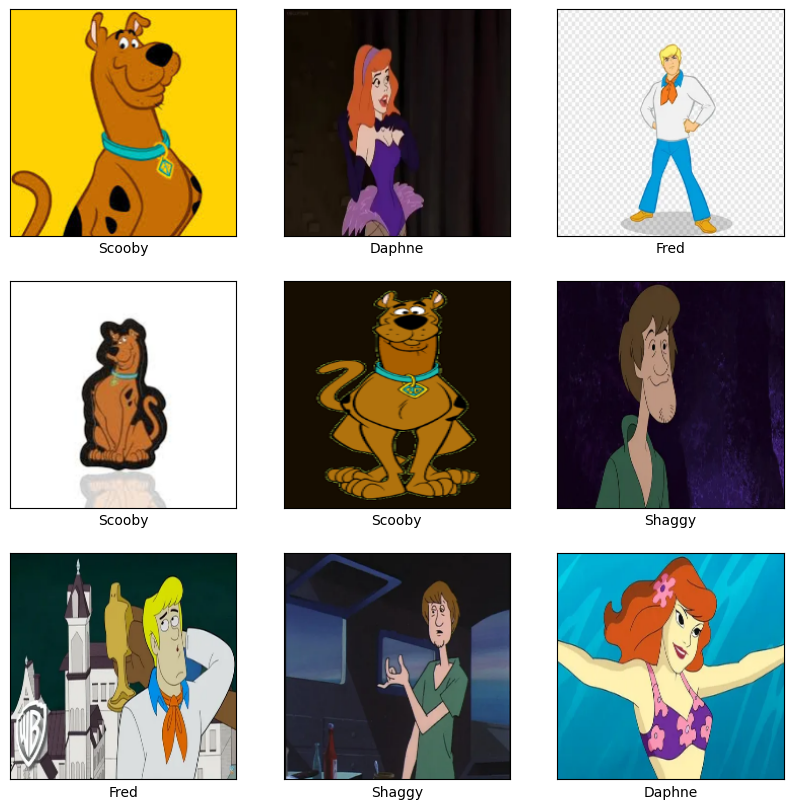

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for x in range(3):
    for y in range(3):
        i = randint(0, len(images)-1)

        axs[x][y].imshow(images[i])

        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])

plt.show()

In [ ]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, bn_size, growth_rate, act_fn ):
        """
        Inputs:
            in_channels - Number of input channels
            bn_size - Bottleneck size (factor of growth rate) for the output of the 1x1 convolution. Typically between 2 and 4.
            growth_rate - Number of output channels of the 3x3 convolution
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            act_fn(),
            nn.Conv2d(in_channels, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False),
        )

    def forward(self, x):
        out = self.net(x)
        out = torch.cat([out, x], dim=1)
        return out

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, num_layers, bn_size, growth_rate, act_fn ):
        """
        Inputs:
            in_channels - Number of input channels
            num_layers - Number of dense layers to apply in the block
            bn_size - Bottleneck size to use in the dense layers
            growth_rate - Growth rate to use in the dense layers
            act_fn - Activation function to use in the dense layers
        """
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            layer_in_channels = in_channels + layer_idx * growth_rate
            layers.append(DenseLayer(in_channels=layer_in_channels, bn_size=bn_size, growth_rate=growth_rate, act_fn=act_fn))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        out = self.block(x)
        return out

In [ ]:
class TransitionLayer(nn.Module):
    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.transition(x)

In [ ]:
class DenseNet(nn.Module):
    def __init__(
        self, num_classes=5, num_layers=[6, 6, 6, 6], bn_size=2, growth_rate=16, act_fn=nn.ReLU, **kwargs
    ):
        super().__init__()
        self.hparams = SimpleNamespace(
            num_classes=num_classes,
            num_layers=num_layers,
            bn_size=bn_size,
            growth_rate=growth_rate,
            act_fn=act_fn,
        )
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.growth_rate * self.hparams.bn_size

        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1)
        )


        blocks = []
        for block_idx, num_layers in enumerate(self.hparams.num_layers):
            blocks.append(
                DenseBlock(
                    in_channels=c_hidden,
                    num_layers=num_layers,
                    bn_size=self.hparams.bn_size,
                    growth_rate=self.hparams.growth_rate,
                    act_fn=self.hparams.act_fn,
                )
            )
            c_hidden = c_hidden + num_layers * self.hparams.growth_rate
            if block_idx < len(self.hparams.num_layers) - 1:
                blocks.append(TransitionLayer(c_in=c_hidden, c_out=c_hidden // 2, act_fn=self.hparams.act_fn))
                c_hidden = c_hidden // 2

        self.blocks = nn.Sequential(*blocks)


        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden),
            self.hparams.act_fn(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams.num_classes),
        )

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [ ]:
num_epochs = 100
batch_size = 32
learning_rate = 0.3
num_classes = 5
patience = 10 # количество эпох которые loss может не уменьшаться перед остановкой обучения

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()

if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train = torch.argmax(y_train, dim=1)
if len(y_val.shape) > 1 and y_val.shape[1] > 1:
    y_val = torch.argmax(y_val, dim=1)


DATA_MEANS = (X_train / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (X_train / 255.0).std(axis=(0, 1, 2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Data mean [0.49791932 0.46327694 0.41514332]
Data std [0.35302223 0.32898843 0.33942471]


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEANS, std=DATA_STD)
])

In [ ]:
dataset_train = DataSet(X_train, y_train,transform)
dataset_test = DataSet(X_val, y_val,transform)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
densenet = DenseNet(num_classes=5, num_layers=[6, 8, 12, 6], bn_size=2, growth_rate=12, act_fn=nn.ReLU).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min',patience=7)

total_step = len(train_loader)
total_step_test = len(test_loader)

best_loss = float('inf')

test_losses = []
train_losses = []
test_accuracies = []
train_accuracies = []


for epoch in range(num_epochs):
    densenet.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = densenet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

    train_losses.append(running_loss / total_step)

    #validating model
    densenet.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        running_loss_test = 0
        best_loss = float('inf')
        for (images, labels) in test_loader:

            images = images.to(device)
            labels = labels.to(device)


            outputs = densenet(images)
            ver, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss_test = criterion(outputs, labels)
            running_loss_test += loss.item()
        val_loss = running_loss_test/total_step_test
        test_losses.append(val_loss)

        scheduler.step(val_loss) # обновляем scheduler по loss
        print('cur loss: ',scheduler.get_last_lr())
        accuracy_test = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy_test:.2f}% ', end='')
        test_accuracies.append(accuracy_test)

        train_correct = 0
        train_total = 0
        for (images, labels) in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = densenet(images)
            ver, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        accuracy = 100 * train_correct / train_total
        print(f', train : {accuracy:.2f}%')
        train_accuracies.append(accuracy)

        # проверка на раннюю остановку
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break


[0.03]
Epoch [1/200], Test Accuracy: 20.00% , train : 23.86%
[0.03]
Epoch [2/200], Test Accuracy: 26.67% , train : 21.59%
[0.03]
Epoch [3/200], Test Accuracy: 20.00% , train : 23.86%
[0.03]
Epoch [4/200], Test Accuracy: 26.67% , train : 21.59%
[0.03]
Epoch [5/200], Test Accuracy: 22.22% , train : 33.52%
[0.03]
Epoch [6/200], Test Accuracy: 15.56% , train : 22.73%
[0.03]
Epoch [7/200], Test Accuracy: 24.44% , train : 35.80%
[0.03]
Epoch [8/200], Test Accuracy: 33.33% , train : 40.91%
[0.03]
Epoch [9/200], Test Accuracy: 48.89% , train : 46.02%
[0.03]
Epoch [10/200], Test Accuracy: 44.44% , train : 44.89%
[0.03]
Epoch [11/200], Test Accuracy: 42.22% , train : 48.86%
[0.03]
Epoch [12/200], Test Accuracy: 64.44% , train : 57.95%
[0.03]
Epoch [13/200], Test Accuracy: 62.22% , train : 63.07%
[0.03]
Epoch [14/200], Test Accuracy: 53.33% , train : 61.93%
[0.03]
Epoch [15/200], Test Accuracy: 46.67% , train : 49.43%
[0.03]
Epoch [16/200], Test Accuracy: 46.67% , train : 60.23%
[0.03]
Epoch [17/

KeyboardInterrupt: 

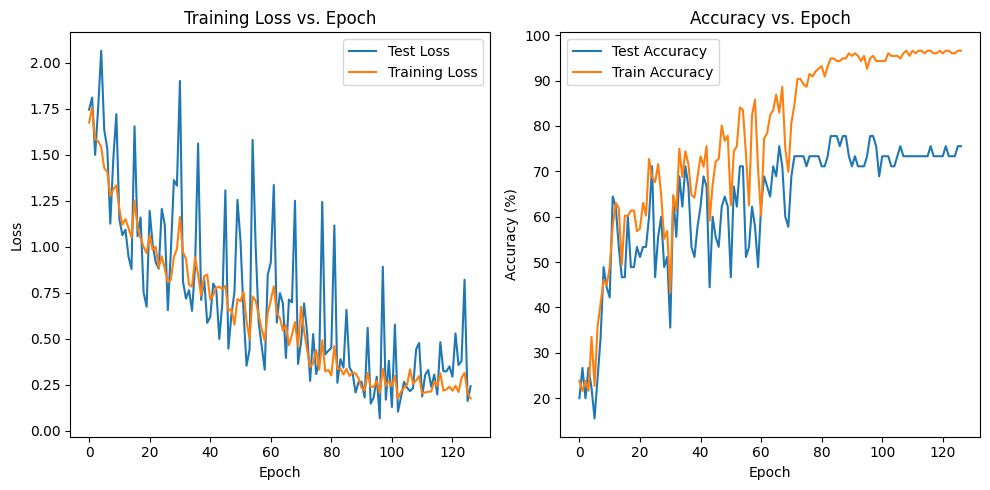

In [ ]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()